# Parseo de file .dat

In [2]:
PARSE_SCRIPT = "./parse.sh"
!chmod +x {PARSE_SCRIPT}

def csv_from_dat(dat_file):
  !{PARSE_SCRIPT} {dat_file + ".dat"}

"chmod" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [3]:
dat_file = "./files/SanEmidio_3D_Model/InputData/Faults/1"
csv_from_dat(dat_file)

"." no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


# Csv a dataframe

In [4]:
#!pip3 install pandas
import pandas as pd

columns= ['x', 'y', 'z', 'faultid', 'lineid']
dataframe = pd.read_csv("./fault_1_parse.csv", header=None, names = columns)

dataframe

,x,y,z,faultid,lineid
0,297022.403131,4.474000e+06,682.399668,1.0,SectionC
1,297650.194000,4.473987e+06,1388.381592,1.0,SectionC
2,295104.806600,4.475887e+06,-2217.032318,1.0,SectionD
3,297521.932164,4.475970e+06,1258.264909,NaN,SectionD
4,297478.412315,4.475970e+06,1197.340614,NaN,SectionD
...,...,...,...,...,...
6532,299960.799207,4.465229e+06,3007.799389,NaN,helper
6533,300651.791281,4.465229e+06,3753.903179,NaN,helper
6534,297604.400271,4.471776e+06,1262.790176,NaN,SectionA
6535,297592.673408,4.471776e+06,1252.805809,NaN,SectionA


# Ploteo de dataframe

In [5]:
# Import libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def plot_dataframe(dataframe):
    # Data from dataset
    z = dataframe['z']
    x = dataframe['x']
    y = dataframe['y']

    # Creating figure
    fig = plt.figure(figsize = (20, 13))
    ax = plt.axes(projection ="3d")

    # Add x, y gridlines 
    ax.grid(b = True, color ='grey', 
            linestyle ='-.', linewidth = 0.3, 
            alpha = 0.2) 


    # Creating color map
    my_cmap = plt.get_cmap('hsv')

    # Creating plot
    sctt = ax.scatter3D(x, y, z,
                        alpha = 0.8,
                        c = (x + y + z), 
                        cmap = my_cmap, 
                        marker ='o')

    plt.title("simple 3D scatter plot")
    ax.set_xlabel('X-axis', fontweight ='bold') 
    ax.set_ylabel('Y-axis', fontweight ='bold') 
    ax.set_zlabel('Z-axis', fontweight ='bold')
    fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

    # show plot
    plt.show()

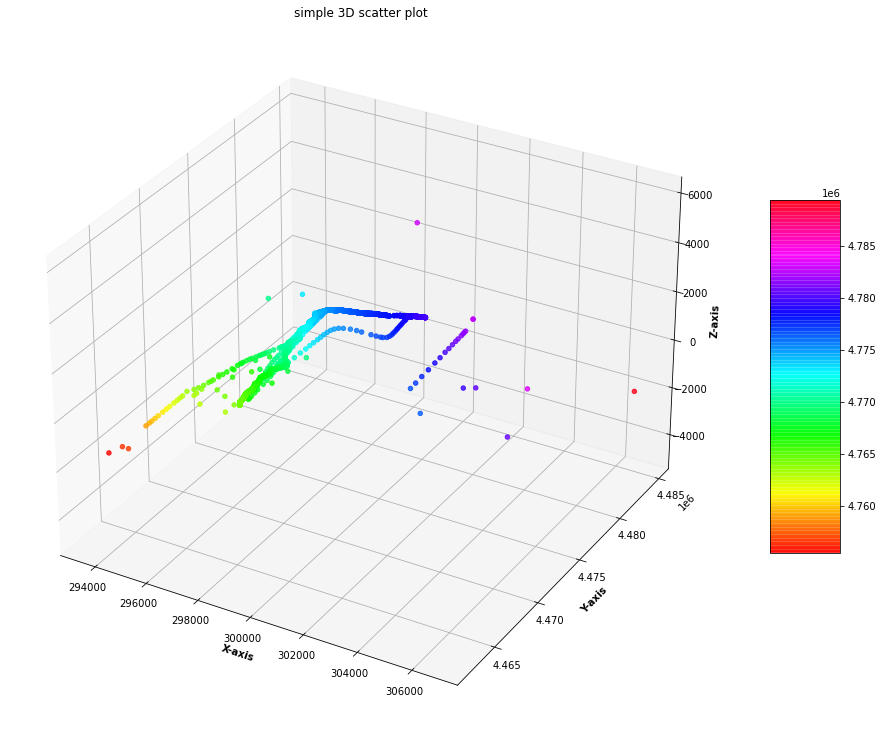

In [6]:
plot_dataframe(dataframe)

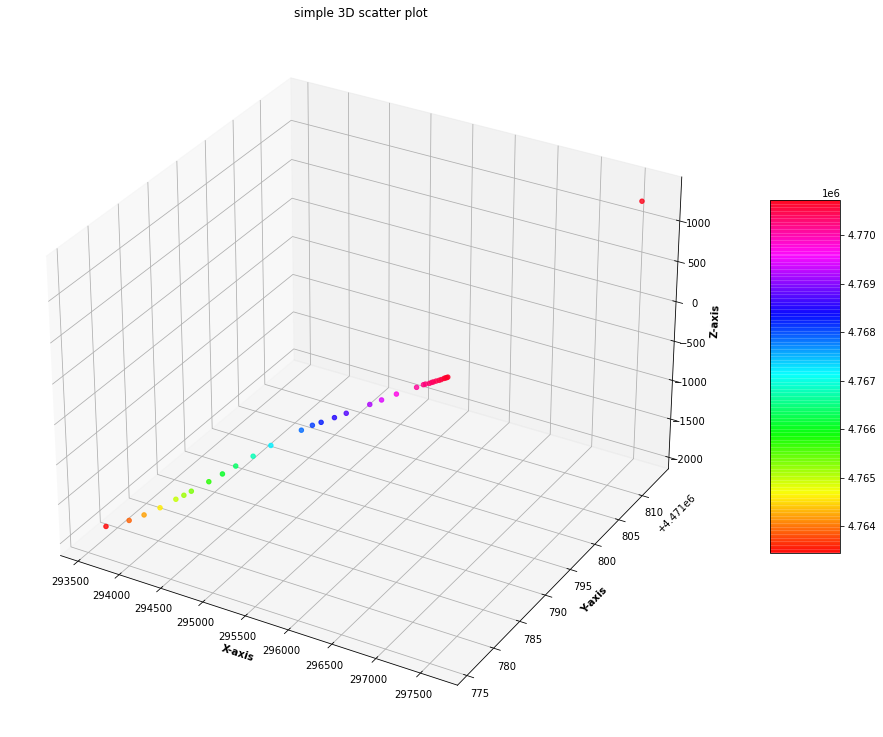

In [7]:
plot_dataframe(dataframe[dataframe['lineid']=="SectionA"])

In [8]:
coords = dataframe[['x','y','z']]
coords

,x,y,z
0,297022.403131,4.474000e+06,682.399668
1,297650.194000,4.473987e+06,1388.381592
2,295104.806600,4.475887e+06,-2217.032318
3,297521.932164,4.475970e+06,1258.264909
4,297478.412315,4.475970e+06,1197.340614
...,...,...,...
6532,299960.799207,4.465229e+06,3007.799389
6533,300651.791281,4.465229e+06,3753.903179
6534,297604.400271,4.471776e+06,1262.790176
6535,297592.673408,4.471776e+06,1252.805809


# Funciones para hacer la SDF

## Forma ineficiente

In [9]:
from math import sqrt


def distanceSquared3D(point, other):
    return sqrt((point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2)


# def isInSphere(spheres, point):
#     for sphere in spheres:
#         if distanceSquared3D(point, sphere[0])< sphere[1]**2:
#             return True
#     return False


# def spheres(coord_and_dist, coordinates_file, distances_file, width, height, max_spheres):  
#     coordinates_spheres = [] #[(Point,r)]
#     for i in range(len(coord_and_dist)):
#         distance = coord_and_dist[i][1]
#         if (distance > 0 and len(coordinates_spheres) < max_spheres):
#             coordinates = coord_and_dist[i][0]
#             coord = (coordinates[0], coordinates[1], coordinates[2])
#             if(not isInSphere(coordinates_spheres, coord)):
#                 coordinates_spheres.append((coord, distance))

#     return coordinates_spheres


def getDistance(x, y, z, index, internalValue="SectionA"):
    coords = dataframe[['x','y','z','lineid']]
    
    realInternalValue = dataframe.loc[index]['lineid']
    # coords.drop([index]) --> not necesary
    
    if realInternalValue == internalValue:
        # filtrar coords: quedarme con los distintos a internalValue
        coords = coords[coords['lineid']!=internalValue]
    else:
        # filtrar coords: quedarme con los de igual a internalValue
        coords = coords[coords['lineid']==internalValue]
    
    distances = []
    for index, row in coords.iterrows():            
        distances.append(distanceSquared3D((x,y,z),(float(row['x']), float(row['y']), float(row['z']))))
    
    min_distance = min(distances)
    if realInternalValue == internalValue:
        return -(min_distance) #hay que restarle 1? que significa ese 1? 
        
    return min_distance
        
    
def dataframe_to_sdf(dataframe): #columns = [x, y, z, faultid, lineid]
    for index, row in dataframe.iterrows():
        distance = getDistance(float(row['x']), float(row['y']), float(row['z']), index)
        dataframe.at[index, 'distance'] = distance
    return dataframe

In [10]:
import time

initial_time=time.time()
sdf = dataframe_to_sdf(dataframe)
end_time=time.time()
print("Calcularlo con 'iterrows' tardo {} segundos".format(end_time-initial_time))
sdf

KeyboardInterrupt: 

## Forma mas eficiente

In [39]:
# Using 'map' function
from math import sqrt


def distanceSquared3D(point, other):
    return sqrt((point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2)


def getDistance(x, y, z, realInternalValue, internalValue = "SectionA", columns = ['x','y','z','lineid']):
    coords = dataframe[columns]
        
    if realInternalValue == internalValue:
        # filtrar coords: quedarme con los distintos a internalValue
        coords = coords[coords[columns[3]]!=internalValue]
    else:
        # filtrar coords: quedarme con los de igual a internalValue
        coords = coords[coords[columns[3]]==internalValue]
    
    distances = coords.apply(lambda row: distanceSquared3D((x,y,z),(float(row[columns[0]]), float(row[columns[1]]), float(row[columns[2]]))), axis=1)
       
    min_distance = distances.min()
    if realInternalValue == internalValue:
        return -(min_distance)
    
    print(min_distance)
    return min_distance
        
    
def dataframe_to_sdf(dataframe, internalValue = "SectionA", columns = ['x','y','z','lineid']): #columns = [x, y, z, faultid, lineid]
    dataframe["distance"] = dataframe.apply(lambda x: getDistance(x[columns[0]], x[columns[1]], x[columns[2]], x[columns[3]], internalValue, columns), axis=1)
    return dataframe

In [37]:
import time

initial_time=time.time()
sdf = dataframe_to_sdf(dataframe)
end_time=time.time()
print("Calcularlo con 'map' tardo {} segundos".format(end_time-initial_time))
sdf

KeyError: 'lineid'

In [ ]:
# distances NaN
sdf[sdf["distance"].isna()]

In [ ]:
# distances not NaN
sdf[sdf["distance"].notna()]

In [ ]:
dataframe[dataframe['lineid']!="SectionC"]

In [ ]:
dataframe.loc[2]['lineid'] == "SectionD"

# Generacion de cubo de tierra (datos)

In [11]:
!pip install noise

  Created wheel for noise: filename=noise-1.2.2-cp38-cp38-win_amd64.whl size=31476 sha256=721cb3e1aa62624f1efb1e31791268957c9f37e41afb03fde9d7f7c9d150d407
  Stored in directory: c:\users\guido\appdata\local\pip\cache\wheels\b3\e1\a8\cf0ce54c603bc4e4965e354a7aa3d8dacb8714f2c2db82ba04
Successfully built noise


In [25]:
import numpy as np
import noise

def generate_terrain():
    shape = (20, 20, 20)
    scale = 100.0
    octaves = 6
    persistence = 0.5
    lacunarity = 2.0

    world = np.zeros(shape)

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                density = noise.pnoise3(i / scale,
                                        j / scale,
                                        k / scale,
                                        octaves=octaves,
                                        persistence=persistence,
                                        lacunarity=lacunarity,
                                        repeatx=1024,
                                        repeaty=1024,
                                        repeatz=1024,
                                        base=42)
                world[i][j][k] = density

    #plot_dataframe(world)
    return world

In [26]:
terrain = generate_terrain()

In [27]:
terrain

array([[[0.        , 0.03258603, 0.0618329 , ..., 0.23677659,
         0.22908203, 0.23123303],
        [0.00326539, 0.03349958, 0.06179116, ..., 0.23497878,
         0.23004799, 0.23200431],
        [0.01080146, 0.03402521, 0.06090566, ..., 0.22904588,
         0.22667468, 0.22599192],
        ...,
        [0.06841178, 0.0551392 , 0.04430683, ..., 0.23193453,
         0.23161632, 0.2364942 ],
        [0.07256555, 0.06019788, 0.05213081, ..., 0.23015973,
         0.22912113, 0.23407307],
        [0.07774235, 0.06595241, 0.06102517, ..., 0.23576322,
         0.23336886, 0.23780766]],

       [[0.03258603, 0.06004842, 0.08003891, ..., 0.23510319,
         0.22625324, 0.22831614],
        [0.03446553, 0.06065301, 0.08070825, ..., 0.23241767,
         0.22653168, 0.22838107],
        [0.03747283, 0.06039054, 0.08373598, ..., 0.22481708,
         0.22253768, 0.22176737],
        ...,
        [0.07415111, 0.06217201, 0.05086714, ..., 0.24214798,
         0.24082111, 0.24386434],
        [0.0

## Funcion para pasar de matriz a dataframe

In [28]:
import pandas as pd
def using_multiindex(A, columns):
    shape = A.shape
    index = pd.MultiIndex.from_product([range(s)for s in shape], names=columns)
    df = pd.DataFrame({'density': A.flatten()}, index=index).reset_index()
    return df

In [29]:
dataframe_terrain = using_multiindex(terrain, list('xyz'))

In [30]:
dataframe_terrain

,x,y,z,density
0,0,0,0,0.000000
1,0,0,1,0.032586
2,0,0,2,0.061833
3,0,0,3,0.082446
4,0,0,4,0.097867
...,...,...,...,...
7995,19,19,15,0.377797
7996,19,19,16,0.366430
7997,19,19,17,0.352210
7998,19,19,18,0.334525


In [31]:
dataframe_terrain[['z']]

,z
0,0
1,1
2,2
3,3
4,4
...,...
7995,15
7996,16
7997,17
7998,18


In [32]:
from math import sqrt


def distanceSquared3D(point, other):
    return sqrt((point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2)


def getDistance(x, y, z, realInternalValue, internalValue = [0,1], columns = ['x','y','z','lineid']):
    coords = dataframe[columns]
    #print("internalValue: {} - realInternalValue: {}".format(internalValue, realInternalValue))
    
    realInternalValueIsAnInternalValue = internalValue[0] <= realInternalValue <= internalValue[1]
    print(realInternalValueIsAnInternalValue)
    if realInternalValueIsAnInternalValue:
        # filtrar coords: quedarme con los distintos a internalValue
        coords = coords[~coords[columns[3]].between(internalValue[0], internalValue[1])]
    else:
        # filtrar coords: quedarme con los de igual a internalValue
        coords = coords[coords[columns[3]].between(internalValue[0], internalValue[1])]
    
    distances = coords.apply(lambda row: distanceSquared3D((x,y,z),(float(row[columns[0]]), float(row[columns[1]]), float(row[columns[2]]))), axis=1)
       
    min_distance = distances.min()
    if realInternalValueIsAnInternalValue:
        return -(min_distance)
    
    #print(min_distance)
    return min_distance
        
    
def dataframe_to_sdf(dataframe, internalValue = [0,1], columns = ['x','y','z','lineid']): #columns = [x, y, z, faultid, lineid]
    dataframe["distance"] = dataframe.apply(lambda x: getDistance(x[columns[0]], x[columns[1]], x[columns[2]], x[columns[3]], internalValue, columns), axis=1)
    return dataframe

In [33]:
#obtengo la densidad de uno de los puntos
dataframe_terrain.iloc[1].density

0.032586026936769485

In [34]:
import time

initial_time=time.time()
internalValue = [0.3,0.34]#dataframe_terrain.iloc[1].density
columns = ['x','y', 'z', 'density']
dataframe = dataframe_terrain
sdf = dataframe_to_sdf(dataframe_terrain, internalValue, columns)
end_time=time.time()
print("Calcularlo con 'map' tardo {} segundos".format(end_time-initial_time))
sdf

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
False
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fal

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
True
True
True
False
False
False
False
False
False
False
True
True
True
True
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
T

,x,y,z,density,distance
0,0,0,0,0.000000,15.811388
1,0,0,1,0.032586,15.524175
2,0,0,2,0.061833,15.297059
3,0,0,3,0.082446,15.132746
4,0,0,4,0.097867,15.033296
...,...,...,...,...,...
7995,19,19,15,0.377797,2.236068
7996,19,19,16,0.366430,1.732051
7997,19,19,17,0.352210,1.000000
7998,19,19,18,0.334525,-1.000000


In [38]:
0.3 < 0.032586

False

# Funcion para crear esferas

In [40]:
len(dataframe)

8000

In [41]:
dataframe

,x,y,z,density,distance
0,0,0,0,0.000000,15.811388
1,0,0,1,0.032586,15.524175
2,0,0,2,0.061833,15.297059
3,0,0,3,0.082446,15.132746
4,0,0,4,0.097867,15.033296
...,...,...,...,...,...
7995,19,19,15,0.377797,2.236068
7996,19,19,16,0.366430,1.732051
7997,19,19,17,0.352210,1.000000
7998,19,19,18,0.334525,-1.000000


In [42]:
dataframe.iloc[0]

x            0.000000
y            0.000000
z            0.000000
density      0.000000
distance    15.811388
Name: 0, dtype: float64

In [48]:
from math import sqrt

def distanceSquared3D(point, other):
    return sqrt((point[0]-other[0])**2 + (point[1]-other[1])**2 + (point[2]-other[2])**2)

def isInSphere(spheres, point):
    for sphere in spheres:
        if distanceSquared3D(point, sphere[0])< sphere[1]:
            return True
    return False

def spheres(dataframe, max_spheres): #dataframe = (x,y,z,density,distance)
    coordinates_spheres = [] #[(Point,r)]
    for i in range(len(dataframe)):
        print(i)
        distance = dataframe.iloc[i].distance
        if (distance > 0 and len(coordinates_spheres) < max_spheres):
            print()
            coord = (dataframe.iloc[i].x, dataframe.iloc[i].y, dataframe.iloc[i].z)
            if(not isInSphere(coordinates_spheres, coord)):
                coordinates_spheres.append((coord, distance))

    return coordinates_spheres

def generateSpheres(dataframe, max_spheres, do_loop, use_brightness_level):
    spheresPoints = spheres(dataframe, max_spheres)
    # plot(circles, use_brightness_level, do_loop)
    return spheresPoints

In [49]:
def generateShader(circles):
    f = "float sphereSD(vec3 p, vec3 pos, float r) { return length(pos - p) - r; }\nfloat sceneSDF(vec3 inputPoint) {\nreturn "
    circle = circles[0]
    prev = "sphereSD(inputPoint, vec3({0}, {1}, {3}), {2})".format(circle[0][0], circle[0][1], float(circle[1]), circle[0][2])
    for i in range(1,len(circles)):
        circle = circles[i]
        opt = "min(sphereSD(inputPoint, vec3({0}, {1}, {4}), {2}), {3})".format(circle[0][0], circle[0][1], float(circle[1]), prev, circle[0][2])
        prev = opt
    f += opt
    f += ";\n}"
    return f

In [50]:
spheres = generateSpheres(dataframe, 10, do_loop=False, use_brightness_level=True)
generateShader(spheres)

0

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100

101

102

103

104

105

106

107

108

109

110

111

112

113

114

115

116

117

118

119

120

121

122

123

124

125

126

127

128

129

130

131

132

133

134

135

136

137

138

139

140

141

142

143

144

145

146

147

148

149

150

151

152

153

154

155

156

157

158

159

160

161

162

163

164

165

166

167

168

169

170

171

172

173

174

175

176

177

178

179

180

181

182

183

184

185

186

187

188

189

190

191

192

193

194

195

196

197

198

199

200

201

202

203

204

205

206

207

208

209

210

211

212

213

214

215

216

217

218

219

220

221




1613

1614

1615

1616

1617

1618

1619

1620

1621

1622

1623

1624

1625

1626

1627

1628

1629

1630

1631

1632

1633

1634

1635

1636

1637

1638

1639

1640

1641

1642

1643

1644

1645

1646

1647

1648

1649

1650

1651

1652

1653

1654

1655

1656

1657

1658

1659

1660

1661

1662

1663

1664

1665

1666

1667

1668

1669

1670

1671

1672

1673

1674

1675

1676

1677

1678

1679

1680

1681

1682

1683

1684

1685

1686

1687

1688

1689

1690

1691

1692

1693

1694

1695

1696

1697

1698

1699

1700

1701

1702

1703

1704

1705

1706

1707

1708

1709

1710

1711

1712

1713

1714

1715

1716

1717

1718

1719

1720

1721

1722

1723

1724

1725

1726

1727

1728

1729

1730

1731

1732

1733

1734

1735

1736

1737

1738

1739

1740

1741

1742

1743

1744

1745

1746

1747

1748

1749

1750

1751

1752

1753

1754

1755

1756

1757

1758

1759

1760

1761

1762

1763

1764

1765

1766

1767

1768

1769

1770

1771

1772

1773

1774

1775

1776

1777

1778

177

3017

3018

3019

3020

3021

3022

3023

3024

3025

3026

3027

3028

3029

3030

3031

3032

3033

3034

3035

3036

3037

3038

3039

3040

3041

3042

3043

3044

3045

3046

3047

3048

3049

3050

3051

3052

3053

3054

3055

3056

3057

3058

3059

3060

3061

3062

3063

3064

3065

3066

3067

3068

3069

3070

3071

3072

3073

3074

3075

3076

3077

3078

3079

3080

3081

3082

3083

3084

3085

3086

3087

3088

3089

3090

3091

3092

3093

3094

3095

3096

3097

3098

3099

3100

3101

3102

3103

3104

3105

3106

3107

3108

3109

3110

3111

3112

3113

3114

3115

3116

3117

3118

3119

3120

3121

3122

3123

3124

3125

3126

3127

3128

3129

3130

3131

3132

3133

3134

3135

3136

3137

3138

3139

3140

3141

3142

3143

3144

3145

3146

3147

3148

3149

3150

3151

3152

3153

3154

3155

3156

3157

3158

3159

3160

3161

3162

3163

3164

3165

3166

3167

3168

3169

3170

3171

3172

3173

3174

3175

3176

3177

3178

3179

3180

3181

3182

3183

4429

4430

4431

4432

4433

4434

4435

4436

4437

4438

4439

4440

4441

4442

4443

4444

4445

4446

4447

4448

4449

4450

4451

4452

4453

4454

4455

4456

4457

4458

4459

4460

4461

4462

4463

4464

4465

4466

4467

4468

4469

4470

4471

4472

4473

4474

4475

4476

4477

4478

4479

4480

4481

4482

4483

4484

4485

4486

4487

4488

4489

4490

4491

4492

4493

4494

4495

4496

4497

4498

4499

4500

4501

4502

4503

4504

4505

4506

4507

4508

4509

4510

4511

4512

4513

4514

4515

4516

4517

4518

4519

4520

4521

4522

4523

4524

4525

4526

4527

4528

4529

4530

4531

4532

4533

4534

4535

4536

4537

4538

4539

4540

4541

4542

4543

4544

4545

4546

4547

4548

4549

4550

4551

4552

4553

4554

4555

4556

4557

4558

4559

4560

4561

4562

4563

4564

4565

4566

4567

4568

4569

4570

4571

4572

4573

4574

4575

4576

4577

4578

4579

4580

4581

4582

4583

4584

4585

4586

4587

4588

4589

4590

4591

4592

4593

4594

4595

6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203
6204
6205
6206
6207
6208
6209
6210
6211
6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372


7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
7986
7987
7988
7989
7990
7991
7992
7993
7994
7995
7996
7997
7998
7999


'float sphereSD(vec3 p, vec3 pos, float r) { return length(pos - p) - r; }\nfloat sceneSDF(vec3 inputPoint) {\nreturn min(sphereSD(inputPoint, vec3(11.0, 11.0, 18.0), 4.123105625617661), min(sphereSD(inputPoint, vec3(11.0, 11.0, 3.0), 2.23606797749979), min(sphereSD(inputPoint, vec3(11.0, 10.0, 12.0), 2.8284271247461903), min(sphereSD(inputPoint, vec3(11.0, 8.0, 9.0), 2.23606797749979), min(sphereSD(inputPoint, vec3(10.0, 12.0, 15.0), 3.1622776601683795), min(sphereSD(inputPoint, vec3(8.0, 19.0, 0.0), 8.54400374531753), min(sphereSD(inputPoint, vec3(2.0, 19.0, 19.0), 11.0), min(sphereSD(inputPoint, vec3(0.0, 14.0, 8.0), 12.165525060596439), min(sphereSD(inputPoint, vec3(0.0, 0.0, 16.0), 15.297058540778355), sphereSD(inputPoint, vec3(0.0, 0.0, 0.0), 15.811388300841896))))))))));\n}'

In [51]:
spheres

[((0.0, 0.0, 0.0), 15.811388300841896),
 ((0.0, 0.0, 16.0), 15.297058540778355),
 ((0.0, 14.0, 8.0), 12.165525060596439),
 ((2.0, 19.0, 19.0), 11.0),
 ((8.0, 19.0, 0.0), 8.54400374531753),
 ((10.0, 12.0, 15.0), 3.1622776601683795),
 ((11.0, 8.0, 9.0), 2.23606797749979),
 ((11.0, 10.0, 12.0), 2.8284271247461903),
 ((11.0, 11.0, 3.0), 2.23606797749979),
 ((11.0, 11.0, 18.0), 4.123105625617661)]